### National Transportation Safety Board Accident/Incident Data

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET  #XML parsing (https://docs.python.org/2/library/xml.etree.elementtree.html)
import numpy as np
import re #regex
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
#Load data
xmltree = ET.parse('AviationData.xml')

data = []
for el in xmltree.iterfind('./*'):
    for i in el.iterfind('*'):
        data.append(dict(i.items()))

#Convert list to dataframe
df = pd.DataFrame(data)


In [3]:
df.head()

,EventId,InvestigationType,AccidentNumber,EventDate,Location,Country,Latitude,Longitude,AirportCode,AirportName,InjurySeverity,AircraftDamage,AircraftCategory,RegistrationNumber,Make,Model,AmateurBuilt,NumberOfEngines,EngineType,FARDescription,Schedule,PurposeOfFlight,AirCarrier,TotalFatalInjuries,TotalSeriousInjuries,TotalMinorInjuries,TotalUninjured,WeatherCondition,BroadPhaseOfFlight,ReportStatus,PublicationDate
0,20150901X74304,Accident,GAA15CA244,09/01/2015,"Truckee, CA",United States,,,,,,,,N786AB,JOE SALOMONE,SUPER CUB SQ2,,,,,,,,,,,,,,Preliminary,
1,20150901X92332,Accident,CEN15LA392,08/31/2015,"Houston, TX",United States,29.809444,-95.668889,IWS,WEST HOUSTON,Non-Fatal,Substantial,Airplane,N452CS,CESSNA,T240,No,,,Part 91: General Aviation,,Instructional,,,,,2,VMC,LANDING,Preliminary,09/04/2015
2,20150902X61853,Accident,GAA15CA246,08/30/2015,"New Milford, CT",United States,,,,,,,,N112RP,CESSNA,170A,,,,,,,,,,,,,,Preliminary,
3,20150901X02521,Accident,GAA15CA243,08/30/2015,"New Enterprise, PA",United States,,,,,,,,N8404X,CESSNA,172C,,,,,,,,,,,,,,Preliminary,
4,20150831X61356,Accident,GAA15CA242,08/29/2015,"MIDLOTHIAN, TX",United States,,,,,,,,N5255G,CESSNA,305A,,,,,,,,,,,,,,Preliminary,


In [5]:
xmltree.getroot().tag

'{http://www.ntsb.gov}DATA'

In [6]:
xmltree.getroot().attrib

{}

In [66]:
def clean_xml_data(df):
    
    #Create date field
    df['EventDate'] = pd.to_datetime(df['EventDate'])
    
    #Subset to US fatalities, since that is the primary interest of the NTSB data
    #Subset data to after 1981, since there are only 4 records prior
    mask = (df['Country'] == 'United States') & (df['EventDate'] > '1981-12-01')
    df_subset = df.loc[mask]
    
    #Replace blank values with NaN
    df_copy = df_subset.replace('', np.nan)
    
    #Clean AirCarrier Names
    df_copy['AirCarrier'] = df_subset['AirCarrier'].str.title()  #convert to lowercase to deal with companies captalized differently
    #TODO: Use "DBA" name if available
    
    #Split States/Cities in Location Field
    df_copy['City'] = df_subset.Location.str.title().str.split(', ', expand=True)[0]
    df_copy['State'] = df_subset.Location.str.upper().str.split(', ', expand=True)[1]
    
    #Strip Number from Injury Serverity Field
    df_copy['fatalities'] = df_subset['InjurySeverity'].str.extract(r'(\d+)')
    df_copy['InjurySeverity'] = df_subset['InjurySeverity'].str.replace('(?<=Fatal).*','')
    
    #Extract variables from date field
    df_copy['year'] = pd.DatetimeIndex(df_subset['EventDate']).year
    df_copy['month'] = pd.DatetimeIndex(df_subset['EventDate']).month
    df_copy['EventDate'] = pd.to_datetime(df_subset['EventDate'])
    
    
    return(df_copy)
    
df_clean = clean_xml_data(df)
df_clean.head()

df_clean.to_csv('aviation_data.csv')

In [67]:
df_clean.EventDate.describe()

/Users/kirsty.ward/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   73068
unique                  12083
top       1984-06-30 00:00:00
freq                       25
first     1982-01-01 00:00:00
last      2015-09-01 00:00:00
Name: EventDate, dtype: object

In [31]:
print('There are {} incidents in the data, with {} columns. The columns available are: {}'.format(df.shape[0], df.shape[1], df.columns.to_list()))

There are 77257 incidents in the data, with 31 columns. The columns available are: ['EventId', 'InvestigationType', 'AccidentNumber', 'EventDate', 'Location', 'Country', 'Latitude', 'Longitude', 'AirportCode', 'AirportName', 'InjurySeverity', 'AircraftDamage', 'AircraftCategory', 'RegistrationNumber', 'Make', 'Model', 'AmateurBuilt', 'NumberOfEngines', 'EngineType', 'FARDescription', 'Schedule', 'PurposeOfFlight', 'AirCarrier', 'TotalFatalInjuries', 'TotalSeriousInjuries', 'TotalMinorInjuries', 'TotalUninjured', 'WeatherCondition', 'BroadPhaseOfFlight', 'ReportStatus', 'PublicationDate']


In [32]:
#Count missing values 
df_clean.isna().sum()

EventId                     0
InvestigationType           0
AccidentNumber              0
EventDate                   2
Location                   33
Country                     0
Latitude                50507
Longitude               50517
AirportCode             30266
AirportName             26618
InjurySeverity              0
AircraftDamage           1856
AircraftCategory        58199
RegistrationNumber        148
Make                       23
Model                      40
AmateurBuilt              273
NumberOfEngines          1507
EngineType               1143
FARDescription          58053
Schedule                63612
PurposeOfFlight          2001
AirCarrier                  0
TotalFatalInjuries      19945
TotalSeriousInjuries    21026
TotalMinorInjuries      19904
TotalUninjured           9389
WeatherCondition          373
BroadPhaseOfFlight       2815
ReportStatus                0
PublicationDate         12462
City                        0
State                      33
fatalities

In [23]:
df_clean['InjurySeverity'].value_counts()[:20]

Non-Fatal      57145
Fatal          13497
Incident        2292
                 106
Unavailable       36
Name: InjurySeverity, dtype: int64

In [136]:
df_clean.describe()

,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,AirportCode,AirportName,AmateurBuilt,BroadPhaseOfFlight,Country,EngineType,...,RegistrationNumber,ReportStatus,Schedule,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition,City,State
count,77257,77257,16520,74873,43477,47331,76603,71030,76747,74048,...,74501,77257,11379,55791,54733,53744,65862,75268,77257,76671
unique,77257,2720,12,3,9488,22283,2,12,173,14,...,67492,4,3,117,62,40,363,3,14542,329
top,LAX86LA318,,Airplane,Substantial,NONE,N/A,No,LANDING,United States,Reciprocating,...,NONE,Probable Cause,UNK,0,0,0,1,VMC,Anchorage,CA
freq,1,73439,14210,55420,1457,1210,69198,18553,73076,63016,...,363,72264,4099,40363,40342,42955,22029,68764,501,8027


In [65]:
df_clean['EventDate'].describe()

count                   73074
unique                  12089
top       1984-06-30 00:00:00
freq                       25
first     1948-10-24 00:00:00
last      2015-09-01 00:00:00
Name: EventDate, dtype: object

In [63]:
for col in df.columns:
    
    print(df_clean[col].value_counts()[0:20])

LAX86LA318     1
SEA02LA170     1
CEN13CA144     1
CEN15LA233     1
BFO93LA086     1
LAX03LA112     1
DEN00FA086     1
NYC91LA054     1
LAX00LA167     1
ANC98LA130     1
MKC90LA021     1
LAX98LA302A    1
FTW02LA074     1
SEA05LA065     1
ERA12FA175     1
ATL83LA162     1
FTW89LA056     1
CHI93LA064     1
ERA10LA184     1
LAX91FA344     1
Name: AccidentNumber, dtype: int64
UNITED AIRLINES                           49
AMERICAN AIRLINES                         41
CONTINENTAL AIRLINES                      25
USAIR                                     24
DELTA AIR LINES INC                       23
AMERICAN AIRLINES, INC.                   22
SOUTHWEST AIRLINES CO                     21
CONTINENTAL AIRLINES, INC.                19
UNITED AIR LINES INC                      14
AMERICAN AIRLINES INC                     12
SIMMONS AIRLINES (DBA: AMERICAN EAGLE)    12
US AIRWAYS INC                            12
TRANS WORLD AIRLINES                      11
DELTA AIRLINES                          

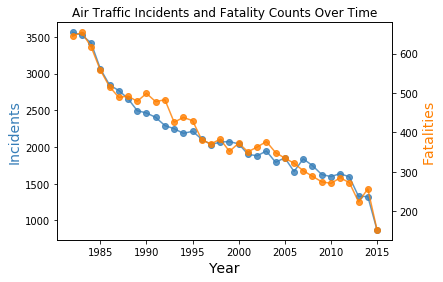

In [79]:
#Plot number of incidents and fatalities over time

#Count incidents and fatalities by year
yearly_incidents = df_clean.groupby('year').agg({'count'}).EventId.reset_index()
yearly_fatalities = df_clean.groupby('year').agg({'count'}).fatalities.reset_index()

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# Plot Yearly Incidents
ax.plot(yearly_incidents['year'], yearly_incidents['count'], color='#377eb8', marker="o", alpha = .8)

# Set axis labels
ax.set_xlabel("Year",fontsize=14)
ax.set_ylabel("Incidents",color='#377eb8',fontsize=14)

# Plot Yearly Fatalities on second axis
ax2=ax.twinx()
ax2.plot(yearly_fatalities['year'], yearly_fatalities['count'],color='#ff7f00',marker="o", alpha = .8)
ax2.set_ylabel("Fatalities",color='#ff7f00',fontsize=14)
plt.title('Air Traffic Incidents and Fatality Counts Over Time')
plt.show()